In [32]:
import cv2
import imutils
import numpy as np
from imutils import contours
from imutils import perspective
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

TypeError: Image data of dtype object cannot be converted to float

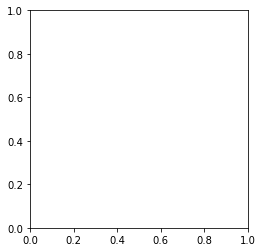

In [33]:
bestFitImage = cv2.imread('mytshirt.jpg')
plt.imshow(bestFitImage)
plt.show()

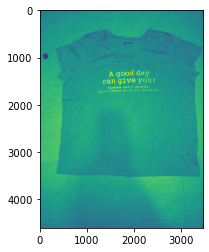

In [19]:
gray = cv2.cvtColor(bestFitImage, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# Let's see how the gray-scaled image looks like
plt.imshow(gray)
plt.show()

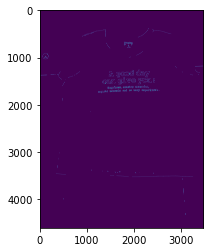

In [20]:
#use better picture -- edges unclear
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Display the result
plt.imshow(edged)
plt.show()

In [22]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)

# Print the result
# print(cnts)

In [23]:
# sort the contours from left-to-right and

(cnts, _) = contours.sort_contours(cnts)
cmax = max(cnts, key=cv2.contourArea)
print(cmax)

[[[1942 1272]]

 [[1941 1273]]

 [[1940 1273]]

 ...

 [[1945 1272]]

 [[1944 1272]]

 [[1943 1272]]]


In [24]:
# Get the image moment and use it to find the centre
M = cv2.moments(cmax)
# print(M)

# Find the center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX, cY)

1841 1345


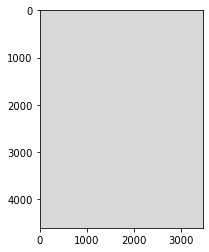

In [25]:
height, width, color = bestFitImage.shape
blank_image = np.zeros((height, width, 3), np.uint8)
blank_image.fill(255) # or img[:] = 255
blank_image =cv2.cvtColor(blank_image, cv2.COLOR_RGB2BGR)
blank_image[:] = (216, 216, 216)
blank_image[:] = (216, 216, 216)

# Display the result
plt.imshow(blank_image)
plt.show()

In [26]:
pixels_per_metric = None
known_width = 0.995 # width of coin

In [28]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [29]:
for c in cnts:
    if cv2.contourArea(c) < 100:
        continue
    orig = bestFitImage.copy()
    
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    
    # Calculate the pixels_per_metric variable
    if pixels_per_metric is None:
        (tl, tr, br, bl) = box
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        pixels_per_metric = dB / known_width

    # If the contour is that of the T-shirt, then calculate the following:
    if cv2.contourArea(c) == cv2.contourArea(cmax):
        cv2.drawContours(blank_image, [cmax], -1, (255, 255, 255), -1)
        # calculate the top for the left sleeve
        leftSleeve_top = tuple(c[c[:, :, 0].argmin()][0])

        # intialize ext bottom ext top and centres
        extBotleft = (0, 0)
        extTop = (0, 0)
        centre = (cX, cY)

        # Calculate the extreme top point of the contour
        for yp in range(cY, 0, -1):
            isOnContour = cv2.pointPolygonTest(c, (cX, yp), False)
            if isOnContour == 0:
                extTop = (cX, yp)
                break
        
        # calculate the bottom left point of the contour
        for xp in range(cX, 0, -1):
            isOnContour = cv2.pointPolygonTest(c, (xp, cY), False)
            if isOnContour == 0:
                extBotleft = (xp, cY)
                break

        widx = dist.euclidean(centre, extBotleft)
        widy = dist.euclidean(centre, extTop)

        extBotRight = (int(cX + widx), cY)
        extDown = (cX, int(cY + widy))

        # calculate the bottom point of the left sleeve
        leftSleeve_bottom = (0, 0)
        yold = leftSleeve_top[1]
        found = False
        for x in cmax:
            for y in x:
                if leftSleeve_bottom != (0, 0):
                    break
                if tuple(y) == leftSleeve_top:
                    found = True
                if found and yold >= y[1]:
                    leftSleeve_bottom = tuple(y)
                else:
                    yold = y[1]

        # Draw points
        cv2.circle(orig, leftSleeve_top, 8, (0, 0, 255), -1)
        cv2.circle(orig, leftSleeve_bottom, 7, (255, 255, 255), -1)
        cv2.circle(orig, extBotleft, 8, (255, 255, 0), -1)
        cv2.circle(orig, extBotRight, 7, (255, 255, 255), -1)
        cv2.circle(orig, extTop, 8, (255, 255, 0), -1)
        cv2.circle(orig, extDown, 7, (255, 255, 255), -1)
        cv2.circle(orig, centre, 8, (255, 255, 0), -1)

        # Calculate the dimensions of the T-shirt! (width, height, and the dimensions of the sleeve)
        outfit_width = widx / pixels_per_metric * 2
        outfit_height = widy / pixels_per_metric * 2
        
        sleevedist = dist.euclidean(leftSleeve_top, leftSleeve_bottom)
        outfit_sleeve = sleevedist / pixels_per_metric
        
        # print the measurements
        print(F"T-shirt width: {outfit_width} inches")
        print(F"T-shirt height: {outfit_height} inches")
        print(F"T-shirt sleeve: {outfit_sleeve} inches")
        
        # Draw and label the measurements on the T-shirt image
        displaypoint = midpoint(leftSleeve_top, leftSleeve_bottom)
        
        cv2.arrowedLine(blank_image, (int(centre[0] - widx), int(centre[1]+widy+60)), (int(centre[0] + widx), int(centre[1]+widy+60)),
                     (0, 0, 0), 2, tipLength=0.05)
        cv2.arrowedLine(blank_image,
                        (int(centre[0] + widx), int(centre[1] + widy + 60)),
                        (int(centre[0] - widx), int(centre[1] + widy + 60)),
                        (0, 0, 0), 2, tipLength=0.05)
        cv2.arrowedLine(blank_image, (int(centre[0] + widx+150), int(centre[1] - widy)), (int(centre[0]+widx+150), int(centre[1] + widy)),
                 (0, 0, 0), 2, tipLength=0.05)
        cv2.arrowedLine(blank_image,  (int(centre[0] + widx + 150), int(centre[1] + widy)),
                        (int(centre[0] + widx + 150), int(centre[1] - widy)),
                        (0, 0, 0), 2, tipLength=0.05)

        cv2.putText(blank_image, "{:.1f}in (sleeve)".format(outfit_sleeve),
                    (int(displaypoint[0]-180), int(displaypoint[1])), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (0, 0, 0), 2)
        cv2.putText(blank_image, "{:.1f}in (width)".format(outfit_width),
                    (int(extDown[0]), int(extDown[1] + 25)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (0, 0, 0), 2)

        cv2.putText(blank_image, "{:.1f}in (height)".format(outfit_height),
                    (int(extBotRight[0] + 10), int(extBotRight[1])), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (0, 0, 0), 2)
        
        plt.imshow(blank_image)
        plt.show()
        
    # Display the result
    plt.imshow(orig)
    plt.show()

NameError: name 'dist' is not defined